# Import Libraries

In [1]:
#+---- Basic Libraries ----+#
import sys, os, time, gc, random
from pathlib import Path
import pandas as pd
import numpy as np
import copy
from utils import *

#+---- Utilities Libraries ----+#
#import albumentations as albu
import pretrainedmodels
from efficientnet_pytorch import EfficientNet
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from PIL import Image
from tqdm.notebook import tqdm
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

#+---- Pytorch Libraries ----+#
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import model_zoo
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

#+---- List the input data ----+#
for dirname, _, filenames in os.walk('../../input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../../input/train.csv
../../input/test.csv
../../input/class_map.csv
../../input/.gitkeep
../../input/sample_submission.csv
../../input/parquet/train_image_data_2.parquet
../../input/parquet/test_image_data_2.parquet
../../input/parquet/train_image_data_3.parquet
../../input/parquet/test_image_data_1.parquet
../../input/parquet/test_image_data_0.parquet
../../input/parquet/test_image_data_3.parquet
../../input/parquet/train_image_data_0.parquet
../../input/parquet/train_image_data_1.parquet
../../input/feather/train_image_data_2.feather
../../input/feather/test_image_data_1.feather
../../input/feather/train_image_data_1.feather
../../input/feather/test_image_data_3.feather
../../input/feather/train_image_data_0.feather
../../input/feather/test_image_data_0.feather
../../input/feather/test_image_data_2.feather
../../input/feather/train_image_data_3.feather


# Initial Settings

## Directories

In [2]:
DATADIR = Path('../../input')
FEATHERDIR = Path('../../input/feather')
OUTDIR = Path('../../output')

In [3]:
os.listdir('../../')

['input', '.gitignore', 'README.md', '.git', 'src', 'submission', 'output']

## Learning Parameters

In [70]:
DEBUG =False
SUBMISSION =False
BATCH_SIZE =32
NUM_EPOCH = 36
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MDL_DIR = '../models'
LOG_DIR = '../logs'
IMAGE_SIZE=224
TRAIN_RATIO = 0.9
WORKER = 4
SEED = 6666
MODEL_NAME ='efficientnet-b4'
N_Fold = 10
CV = True
Fold = 2
PATIAENCE = 4
VER = 'fold_2'

In [63]:
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant

# Dataset

## Transform class for data preprocessing and augmentations

In [6]:
def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images

In [7]:
def crop_char_image(image, threshold=5./255.):
    assert image.ndim == 2
    is_black = image > threshold

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    left = np.argmax(is_black_horizontal)
    right = np.argmax(is_black_horizontal[::-1])
    top = np.argmax(is_black_vertical)
    bottom = np.argmax(is_black_vertical[::-1])
    height, width = image.shape
    cropped_image = image[left:height - right, top:width - bottom]
    return cropped_image

In [8]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.ColorJitter(0.5,0.5,0.5,0.5),
        transforms.RandomAffine(degrees=0.6),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
    ]),
    'val': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.ToPILImage(),
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [9]:
class BengaliAIDataset(Dataset):
    def __init__(self, images, labels=None, transform=None, indices=None):
        self.transform = transform
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)
      
    def __getitem__(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) #/ 255.
        x = crop_char_image(x)
        x = Image.fromarray(x).convert("RGB")
        x = self.transform(x)
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x

## Import Data

In [10]:
train = pd.read_csv(DATADIR/'train.csv')
train['id'] = train['image_id'].apply(lambda x: int(x.split('_')[1]))
X, y = train[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']]\
.values[:,0], train.values[:,1:]
train['fold'] = np.nan
mskf = MultilabelStratifiedKFold(n_splits=N_Fold)
for i, (_, index) in enumerate(mskf.split(X, y)):
    print('Fold '+str(i+1))
    train.iloc[index, -1] = i
train['fold'] = train['fold'].astype('int')

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9
Fold 10


In [ ]:
%%time
#train = pd.read_csv(DATADIR/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if DEBUG else [0, 1, 2, 3]
train_images = prepare_image(
    DATADIR, FEATHERDIR, data_type='train', submission=False, indices=indices)

In [71]:
n_dataset = len(train_images)

if not CV:
    train_data_size = 200 if DEBUG else int(n_dataset * TRAIN_RATIO)
    valid_data_size = 100 if DEBUG else int(n_dataset - train_data_size)
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)

    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['train'],
        indices=perm[:train_data_size])

    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['val'],
        indices=perm[train_data_size:train_data_size+valid_data_size])
else:
    valid_idx = np.array(train[train['fold']==Fold].index)
    trn_idx = np.array(train[train['fold']!=Fold].index)
    trn_idx = trn_idx[:200] if DEBUG else trn_idx
    valid_idx = valid_idx[:100] if DEBUG else valid_idx
    
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['train'],
        indices=trn_idx)
    valid_dataset = BengaliAIDataset(
        train_images, train_labels, transform=data_transforms['val'],
        indices=valid_idx)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKER)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKER)

dataloaders = {'train':train_loader, 'val': valid_loader}
dataset_sizes = {'train':len(train_dataset), 'val': len(valid_dataset)}

In [72]:
trn_idx

array([     0,      1,      2, ..., 200837, 200838, 200839])

In [73]:
image, label = train_dataset[1]
print('image', image.shape, 'label', label)

image torch.Size([3, 224, 224]) label [159   0   0]


# Define Model/Train functions

In [78]:
def train_model(model, dataloaders, criterion, optimizer, scheduler,start_epoch, num_epochs, device, patiance):
    since = time.time()
    
    trn_loss_list =[]
    trn_acc_list = []
    val_loss_list =[]
    val_acc_list = []
    epoch_list = []
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    torch.backends.cudnn.benchmark = True
    early_stopping_counter = 0

    for epoch in range(num_epochs)[start_epoch:]:
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        if early_stopping_counter == patiance:
            print(f'Early Stopped since loss have not decreased for {patiance} epoch.')
            break
        epoch_list.append(epoch)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            epoch_loss = 0.0
            epoch_corrects = 0
            dataset_sizes = len(dataloaders[phase].dataset)

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                #print(inputs.shape)
                inputs = inputs.to(device)
                labels = labels.transpose(1,0).to(device) #use when single label for one image

                grapheme_root = labels[0]
                vowel_diacritic = labels[1]
                consonant_diacritic = labels[2]


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) 
                    #_, preds = torch.max(outputs, 1)
                    #outputs shape is tuple with (bs, num_class1), (bs, num_class2), (bs, num_class3)
                    grapheme_root_prd = outputs[0]
                    vowel_diacritic_prd = outputs[1]
                    consonant_diacritic_prd = outputs[2]


                    #loss = criterion(outputs, labels)
                    #output shape : (batch size, class number)
                    #label shape : batch size
                    loss = (1/3)*(criterion(grapheme_root_prd, grapheme_root)+\
                                criterion(vowel_diacritic_prd, vowel_diacritic) +\
                                  criterion(consonant_diacritic_prd, consonant_diacritic))
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics: inputs.size(0) is batch size
                epoch_loss += loss.item() * inputs.size(0) # total loss for this batch
                epoch_corrects += torch.sum(torch.max(outputs[0], 1)[1] == labels[0])+\
                    torch.sum(torch.max(outputs[1], 1)[1] == labels[1])+\
                    torch.sum(torch.max(outputs[2], 1)[1] == labels[2])
            if phase == 'val':
                #scheduler.step()
                # if plateau scheduler use following
                scheduler.step(epoch_loss)

            epoch_loss = epoch_loss / dataset_sizes
            epoch_acc = epoch_corrects.double() / (dataset_sizes*3)
            
            if phase == 'train':
                trn_loss_list.append(epoch_loss)
                trn_acc_list.append(epoch_acc.cpu().numpy())

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if not os.path.exists(f'{MDL_DIR}/{MODEL_NAME}_{VER}'):
                    os.mkdir(f'{MDL_DIR}/{MODEL_NAME}_{VER}')
                save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(epoch)+'.pth'
                torch.save(model_ft.state_dict(),save_path)
                best_epoch = epoch
            
            if phase == 'val':
                val_loss_list.append(epoch_loss)
                val_acc_list.append(epoch_acc.cpu().numpy())
                # Early Stopping
                if epoch == 0 or epoch == start_epoch:
                    best_loss = epoch_loss
                else:
                    if epoch_loss < best_loss:
                        best_loss = epoch_loss
                    else:
                        early_stopping_counter += 1
                        print(f'Early stopping counter: {early_stopping_counter}')
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    log = pd.DataFrame()
    log['Epoch'] = epoch_list
    log['Train Loss'] = trn_loss_list
    log['Train Acc'] = trn_acc_list
    log['Valid Loss'] = val_loss_list
    log['Valid Acc'] = val_acc_list
    log.to_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv',index=False)
        
    return model, best_epoch

In [15]:
class bengali_model(nn.Module):
    def __init__(self, num_classes1, num_classes2, num_classes3):
        super(bengali_model, self).__init__()
        #pretrain models
        #self.model = pretrainedmodels.__dict__[MODEL_NAME](pretrained=None)
        #num_ftrs = self.model.last_linear.in_features
        #self.model.last_linear = nn.Identity()
        
        # EfficientNet
        self.model = EfficientNet.from_pretrained(MODEL_NAME)
        num_ftrs = 1792
        
        self.fc1 = nn.Linear(num_ftrs, num_classes1)
        self.fc2 = nn.Linear(num_ftrs, num_classes2)
        self.fc3 = nn.Linear(num_ftrs, num_classes3)

    def forward(self, x):
        #x = self.model(x) #pretrain models
        bs, _, _, _ = x.shape
        x = self.model.extract_features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        out1 = self.fc1(x)
        out2 = self.fc2(x)
        out3 = self.fc3(x)
        return out1, out2, out3

In [16]:
EfficientNet.from_pretrained(MODEL_NAME).extract_features

Loaded pretrained weights for efficientnet-b4


<bound method EfficientNet.extract_features of EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv

In [80]:
# --- Model --- Stage 1

model_ft = bengali_model(n_grapheme, n_vowel, n_consonant)
model_ft = model_ft.to(DEVICE)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=5, min_lr=1e-10)

Loaded pretrained weights for efficientnet-b4


In [81]:
torch.cuda.empty_cache()
#gc.collect()

In [82]:
# fold 1 Best val Acc: 0.974806
# fold 2 Best val Acc: 0.975171 
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,0, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 1/36
----------



train Loss: 0.3160 Acc: 0.9103



val Loss: 0.1834 Acc: 0.9481
Epoch 2/36
----------



train Loss: 0.1498 Acc: 0.9568



val Loss: 0.1405 Acc: 0.9619
Epoch 3/36
----------



train Loss: 0.1179 Acc: 0.9659



val Loss: 0.1240 Acc: 0.9661
Epoch 4/36
----------



train Loss: 0.0975 Acc: 0.9719



val Loss: 0.1205 Acc: 0.9680
Epoch 5/36
----------



train Loss: 0.0818 Acc: 0.9761



val Loss: 0.1171 Acc: 0.9690
Epoch 6/36
----------



train Loss: 0.0715 Acc: 0.9789



val Loss: 0.1119 Acc: 0.9702
Epoch 7/36
----------



train Loss: 0.0626 Acc: 0.9813



val Loss: 0.1093 Acc: 0.9722
Epoch 8/36
----------



train Loss: 0.0549 Acc: 0.9833



val Loss: 0.1019 Acc: 0.9752
Epoch 9/36
----------



train Loss: 0.0496 Acc: 0.9849



val Loss: 0.1084 Acc: 0.9728
Early stopping counter: 1
Epoch 10/36
----------



train Loss: 0.0436 Acc: 0.9867



val Loss: 0.1075 Acc: 0.9739
Early stopping counter: 2
Epoch 11/36
----------



train Loss: 0.0391 Acc: 0.9878



val Loss: 0.1126 Acc: 0.9739
Early stopping counter: 3
Epoch 12/36
----------



train Loss: 0.0364 Acc: 0.9886



val Loss: 0.1072 Acc: 0.9751
Early stopping counter: 4
Epoch 13/36
----------
Early Stopped since loss have not decreased for 4 epoch.
Training complete in 1541m 55s
Best val Acc: 0.975171


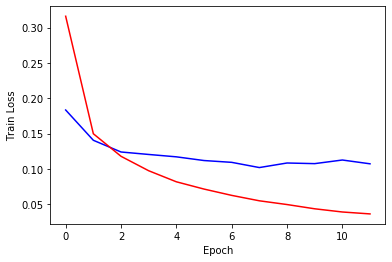

In [83]:
log = pd.read_csv(f'{LOG_DIR}/log_{MODEL_NAME}_{VER}.csv')
sns.lineplot(x=log['Epoch'], y=log['Valid Loss'], color='blue')
sns.lineplot(x=log['Epoch'], y=log['Train Loss'], color='red')
plt.show()

In [88]:
# --- Model --- Stage 2

model_ft = model_ft.to(DEVICE)

save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.0001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.7, patience=2, min_lr=1e-10)

In [89]:
model_ft, best_epoch = train_model(model_ft, dataloaders, criterion, optimizer, scheduler,6, NUM_EPOCH, DEVICE, PATIAENCE)

Epoch 7/36
----------



train Loss: 0.0225 Acc: 0.9931



val Loss: 0.0832 Acc: 0.9810
Epoch 8/36
----------



train Loss: 0.0136 Acc: 0.9960



val Loss: 0.0884 Acc: 0.9810
Early stopping counter: 1
Epoch 9/36
----------



train Loss: 0.0095 Acc: 0.9971



val Loss: 0.0958 Acc: 0.9809
Early stopping counter: 2
Epoch 10/36
----------



train Loss: 0.0069 Acc: 0.9979



val Loss: 0.0997 Acc: 0.9811
Early stopping counter: 3
Epoch 11/36
----------



train Loss: 0.0046 Acc: 0.9987



val Loss: 0.1055 Acc: 0.9813
Early stopping counter: 4
Epoch 12/36
----------
Early Stopped since loss have not decreased for 4 epoch.
Training complete in 641m 14s
Best val Acc: 0.981328


# Evaluation

In [24]:
def macro_recall(pred_labels, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
           f'total {final_score}')
    return final_score

In [25]:
def predict(model, dataloaders, phase, device):
    model.eval()
    output_list = []
    label_list = []
    with torch.no_grad():
        if phase == 'test':
            for i, inputs in enumerate(tqdm(dataloaders)):
                
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, pred0 = torch.max(outputs[0], 1)
                _, pred1 = torch.max(outputs[1], 1)
                _, pred2 = torch.max(outputs[2], 1)
                preds = (pred0, pred1, pred2)
                output_list.append(preds)
            return output_list
        elif phase == 'val':
            for i, (inputs, labels) in enumerate(tqdm(dataloaders)):
                
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, pred0 = torch.max(outputs[0], 1)
                _, pred1 = torch.max(outputs[1], 1)
                _, pred2 = torch.max(outputs[2], 1)
                preds = (pred0, pred1, pred2)
                output_list.append(preds)
                label_list.append(labels.transpose(1,0))
            return output_list, label_list

In [90]:
save_path = f'{MDL_DIR}/{MODEL_NAME}_{VER}/{MODEL_NAME}_'+str(best_epoch)+'.pth'
load_weights = torch.load(save_path)
model_ft.load_state_dict(load_weights)

<All keys matched successfully>

In [91]:
# --- Prediction ---
data_type = 'val'
valid_preds_list = []
print('valid_dataset', len(valid_dataset))
valid_preds_list, valid_label_list = predict(model_ft, valid_loader, data_type, DEVICE)
gc.collect()

valid_dataset 20084


12

In [92]:
# Each test_preds indicates the prediction outputs of different batch
p0 = np.concatenate([valid_preds[0].cpu().numpy() for valid_preds in valid_preds_list], axis=0)
p1 = np.concatenate([valid_preds[1].cpu().numpy() for valid_preds in valid_preds_list], axis=0)
p2 = np.concatenate([valid_preds[2].cpu().numpy() for valid_preds in valid_preds_list], axis=0)
print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

a0 = np.concatenate([valid_label[0].cpu().numpy() for valid_label in valid_label_list], axis=0)
a1 = np.concatenate([valid_label[1].cpu().numpy() for valid_label in valid_label_list], axis=0)
a2 = np.concatenate([valid_label[2].cpu().numpy() for valid_label in valid_label_list], axis=0)
print('a0', a0.shape, 'a1', a1.shape, 'a2', a2.shape)

pred_labels = [p0, p1, p2]
y = [a0, a1, a2]
macro_recall(pred_labels, y, n_grapheme=168, n_vowel=11, n_consonant=7)
#fold 1 Stage-1 CV :0.9659313780016296 --> Stage-2 0.9666139805270331
#fold 2 Stage-1 CV :0.9698549400969805 --> Stage 2 0.9743222464903162

p0 (20084,) p1 (20084,) p2 (20084,)
a0 (20084,) a1 (20084,) a2 (20084,)
recall: grapheme 0.9645096549282974, vowel 0.9897832940731021, consonant 0.978486382031568, total 0.9743222464903162


0.9743222464903162

# Inference

In [ ]:
# --- Prediction ---
data_type = 'test'
test_preds_list = []
for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        DATADIR, FEATHERDIR, data_type = data_type, submission=True, indices=indices)
    n_dataset = len(test_images)
    print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)
    test_dataset = BengaliAIDataset(
    test_images, None,
    transform=data_transforms[data_type])
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKER)
    
    test_preds_list = predict(model_ft, test_loader, data_type,DEVICE)
    del test_images
    gc.collect()
    if DEBUG:
        break

In [ ]:
# Each test_preds indicates the prediction outputs of different batch
p0 = np.concatenate([test_preds[0].cpu().numpy() for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1].cpu().numpy() for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2].cpu().numpy() for test_preds in test_preds_list], axis=0)
print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    row_id += [f'Test_{i}_grapheme_root', f'Test_{i}_vowel_diacritic',
               f'Test_{i}_consonant_diacritic']
    target += [p0[i], p1[i], p2[i]]
pred_df = pd.DataFrame({'row_id': row_id, 'target': target})

In [ ]:
pred_df.to_csv('submission.csv', index=False)